In [1]:
from scipy.special import erfc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Call price')

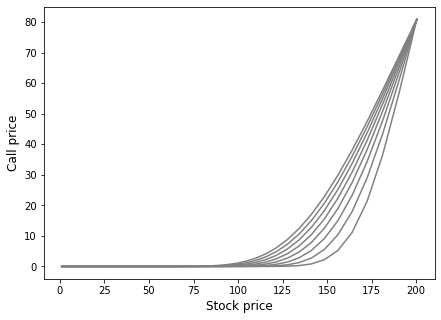

In [63]:
dt = 0.005 # grid size for time 
dx = 0.05 # grid size for x 
sigma = 0.3
r = 0.04
K = 100
x_max = np.log(200) # ????
t_max = x_max # total time in s
 
# function to calculate call profiles based on a 
# finite difference approximation to the 1D 
# equation and the FTCS scheme:
def call_FTCS(dt,dx,t_max,x_max,r,sigma):
    # diffusion number (has to be less than 0.5 for the 
    # solution to be stable):
    b1 = (r-(sigma**2)/2)*(dt/(2*dx)) + ((sigma**2)/2)*(dt/(dx**2))
    b0 = 1 - (sigma**2)*(dt/(dx**2)) - r*dt
    b_1 = ((sigma**2)/2)*(dt/(dx**2)) - (r-(sigma**2)/2)*(dt/(2*dx))
    x = np.arange(0,x_max+dx,dx) 
    t = np.arange(0,t_max+dt,dt)
    T = len(t)
    X = len(x)
    V = np.zeros([T,X])
    V[:,0] = 0
    V[:,X-1] = K*np.exp(-r*t_max)
    V[T-1,:] = K*np.exp(-r*t_max)
    for n in range(0,T-1): # time
        for j in range(1,X-1): # space
            V[n+1,j] = b1*V[n,j+1] + b0*V[n,j] + b_1*V[n,j-1]
    S = np.exp(x)
    return S,V
# note that this can be written without the for-loop 
# in space, but it is easier to read it this way

def black_scholes(self,S, K, T, r, sigma, call_put='call'):   
    """Return black scholes price of an option"""
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    if call_put == 'call':
        optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        return optionprice

def diffusion_analytic(t,h,V0,dy,viscosity):
    y = np.arange(0,h+dy,dy)
    eta1 = h/(2*(t*viscosity)**0.5)
    eta = y/(2*(t*viscosity)**0.5)
    sum1 = 0
    sum2 = 0
    for n in range(0,1000):
        sum1 = sum1 + erfc(2*n*eta1+eta)
        sum2 = sum2 + erfc(2*(n+1)*eta1-eta)
    V_analytic = V0*(sum1-sum2)
    return V_analytic
 
S,V = call_FTCS(dt,dx,t_max,x_max,r,sigma)
# plotting:
plt.figure(figsize=(7,5))
plot_times = np.arange(0.2,1.0,0.1)
for t in plot_times:
    plt.plot(S,V[int(t/dt),:],color='Gray')
    V_analytic = diffusion_analytic(t,0.04,40,dy,viscosity)
    plt.plot(y,V_analytic,'ok',label='analytic',
        markersize=3)
plt.xlabel('Stock price',fontsize=12)
plt.ylabel('Call price',fontsize=12)


In [ ]:
def call_Crank_Nicolson(dy,ny,dt,nt,D,V,ntout):
    Vout = [] # list for storing V arrays at certain time steps
    V0 = V[0] # boundary condition on left side
    V1 = V[-1] # boundary condition on right side
    s = D*dt/dy**2  # diffusion number
    # create coefficient matrix:
    A = diags([-0.5*s, 1+s, -0.5*s], [-1, 0, 1], 
          shape=(ny-2, ny-2)).toarray() 
    B1 = diags([0.5*s, 1-s, 0.5*s],[-1, 0, 1], shape=(ny-2, ny-2)).toarray()
    for n in range(1,nt): # time is going from second time step to last
        Vn = V
        B = np.dot(Vn[1:-1],B1) 
        B[0] = B[0]+0.5*s*(V0+V0)
        B[-1] = B[-1]+0.5*s*(V1+V1)
        V[1:-1] = np.linalg.solve(A,B)
        if n % int(nt/float(ntout)) == 0 or n==nt-1:
            Vout.append(V.copy()) # numpy arrays are mutable, 
            #so we need to write out a copy of V, not V itself
    return Vout,s
 
dt = 0.001 # grid size for time (s)
dy = 0.001 # grid size for space (m)
viscosity = 2*10**(-4) # kinematic viscosity of oil (m2/s)
y_max = 0.04 # in m
y = np.arange(0,y_max+dy,dy) 
ny = len(y)
nt = 1000
plt.figure(figsize=(7,5))
V = np.zeros((ny,)) # initial condition
V[0] = 10
Vout,s = diffusion_Crank_Nicolson(dy,ny,dt,nt,viscosity,V,10)
 
for V in Vout:
    plt.plot(y,V,'k')
plt.xlabel('distance from wall (m)',fontsize=12)
plt.ylabel('velocity (m/s)',fontsize=12)
plt.axis([0,y_max,0,V[0]])
plt.title('Crank-Nicolson scheme',fontsize=14);